# Plot data on a map

`poligrain` shall make your live easier when plotting data as points, lines and grids. In particular plotting lines from CML paths using a colormap will be easy now.

Since we enforce a fixed naming convention of site cooridnates in the `xarray.Dataset`s that we use, we do not have to fiddle with these during plotting. We can just take a `Dataset` or a `DataArray` as input for our plotting functions.

In [1]:
import matplotlib.pyplot as plt

import poligrain as plg

## Load OpenMRG example data

This is a small subset of the full OpenMRG dataset from https://zenodo.org/records/7107689 for which CML data was processed and all data are provided at a 5-minute resolution.

In [2]:
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg_5min_2h(data_dir="example_data")

File already exists at example_data/openmrg_cml_5min_2h.nc
Not downloading!
File already exists at example_data/openmrg_rad_5min_2h.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_5min_2h.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_5min_2h.nc
Not downloading!


## Plot CML paths 

If we have CML data in a `xarray.Dataset` with our naming convention we can simply pass the `Dataset` to the plotting function to plot all CML paths onto a map. The lines are draw in one go using `LineCollection` of `matplotlib`, and not using a for-loop to iterate over the CMLs, so the plotting function is very fast also for large CML networks.

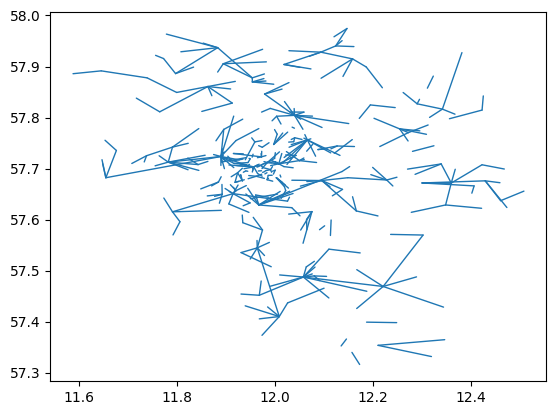

In [3]:
plg.plot_map.plot_lines(ds_cmls);

We can plot directly from the `xarray.Dataset` using the custom Accessor available via `.plg`

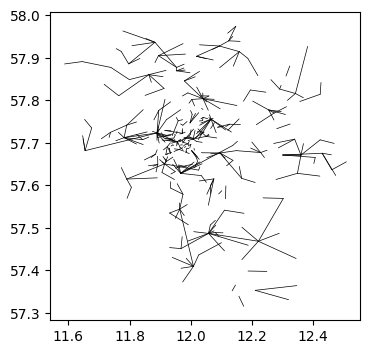

In [4]:
fig, ax = plt.subplots(figsize=(4, 4))
ds_cmls.plg.plot_cmls(line_width=0.5, ax=ax, line_color="k");

If we use an `xarray.DataArray`, as a subset of the CML `Dataset` that we did load above, we can easily color the lines based on the values of each CML.

Note that there must not be more than one value per CML, i.e. you have to subset to one `sublink_id` (if you have two, which is the common case) and to one `time` step.

Below, this is shown for the rain rate per CML from a processed example data. Here only one sublink is provide, hence, we do not have to subset.

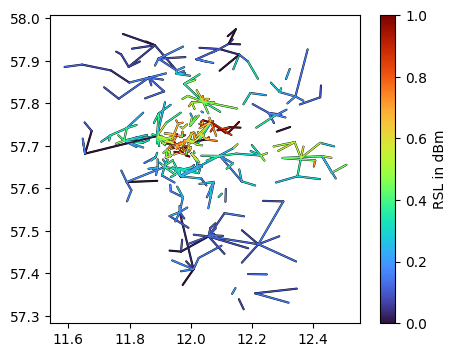

In [5]:
da_R = ds_cmls.R.isel(time=11)

fig, ax = plt.subplots(figsize=(5, 4))
lines = da_R.plg.plot_cmls(pad_width=0.5, cmap="turbo", vmin=0, vmax=1, ax=ax)
plt.colorbar(lines, label="RSL in dBm");

This way, we can also easily add color based on CML frequency.

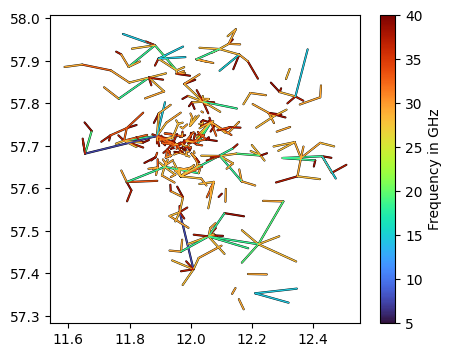

In [6]:
fig, ax = plt.subplots(figsize=(5, 4))
da_f_GHz = ds_cmls.frequency / 1e3
lines = da_f_GHz.plg.plot_cmls(pad_width=0.5, vmin=5, vmax=40, cmap="turbo", ax=ax)
plt.colorbar(lines, label="Frequency in GHz");

## Plot SML paths

to be added...

## Plot gauges

to be added...

## Plot radar data

to be added...

## Plot all sensors at the same time

to be added...